In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

Load dataset and prepare data

In [2]:
fldr = "./UTkFace"
files = os.listdir(fldr)
ages = []
genders = []
images = []

In [3]:
def get_shirt_color(image):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 30])
    
    mask_white = cv2.inRange(image, lower_white, upper_white)
    mask_black = cv2.inRange(image, lower_black, upper_black)
    
    if np.sum(mask_white) > np.sum(mask_black):
        return 'white'
    elif np.sum(mask_black) > np.sum(mask_white):
        return 'black'
    else:
        return 'none'

In [4]:
for fle in files:
    age = int(fle.split('_')[0])
    gender = int(fle.split('_')[1])
    total = fldr + '/' + fle
    image = cv2.imread(total)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))
    images.append(image)
    ages.append(age)
    genders.append(gender)

In [5]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)
np.save(fldr + 'image.npy', images_f)
np.save(fldr + 'ages.npy', ages_f)
np.save(fldr + 'genders.npy', genders_f)

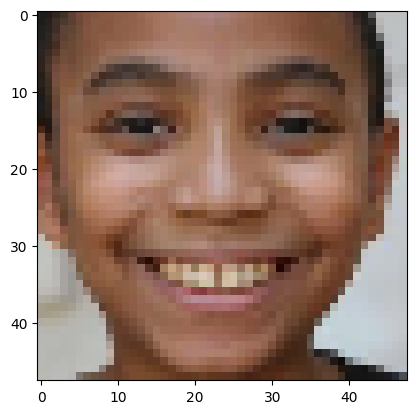

10
0
[12391 11317]


In [6]:
values, counts = np.unique(genders_f, return_counts=True)
plt.imshow(images[87])
plt.show()
print(ages[87])
print(genders[87])
print(counts)

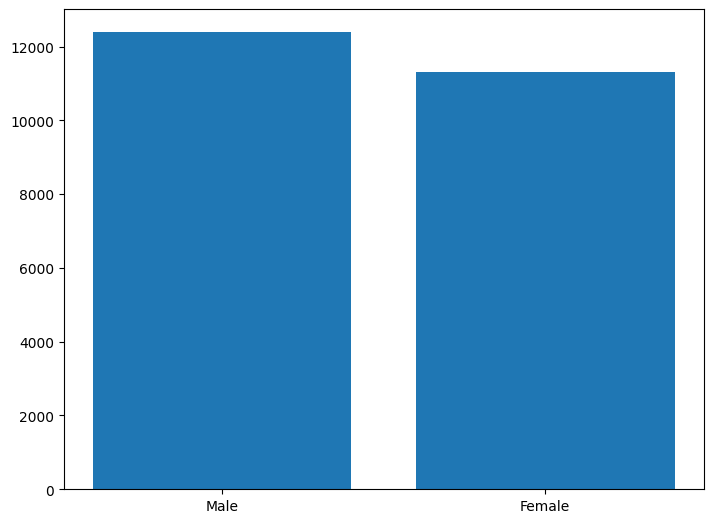

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
gender = ['Male', 'Female']
values = [12391, 11317]
ax.bar(gender, values)
plt.show()

In [8]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[1123  482  289  273  196  131  139  263  166  156   65  130   81  157
  177  247  158  262   98  284  346  395  426  859  734 2197  615  918
  570  724  350  664  143  409  880  483  293  325  266  526  132  266
  157  100  440  153  170  153  148  381  138  232  241  353  268  236
   97  271   82  293  161  125  103   50  259   77   94  100   56  147
   33   98   63   32  148   58   28   69   23  133   22   40   18   24
  155   35   10   34   33   82    2   13    5    9   17    9   11    2
    1    5    5    1    3    4]


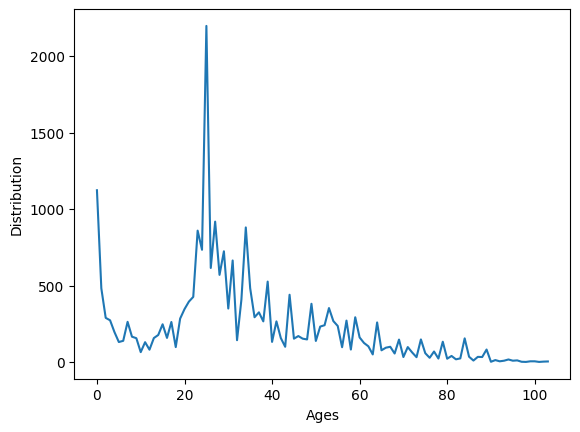

In [9]:
plt.plot(counts)
plt.xlabel('Ages')
plt.ylabel('Distribution')
plt.show()

In [10]:
labels = []
for i in range(len(ages)):
    labels.append([ages[i], genders[i]])
labels_f = np.array(labels)

In [11]:
images_f_2 = images_f / 255.0
X_train, X_test, Y_train, Y_test = train_test_split(images_f_2, labels_f, test_size=0.25)
Y_train_2 = [Y_train[:, 1], Y_train[:, 0]]
Y_test_2 = [Y_test[:, 1], Y_test[:, 0]]

In [12]:
def Convolution(input_tensor, filters):
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x = Activation('relu')(x)
    return x

In [13]:
def build_model(input_shape):
    inputs = Input((input_shape))
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Convolution(maxp_1, 64)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = Convolution(maxp_2, 128)
    maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
    conv_4 = Convolution(maxp_3, 256)
    maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
    conv_5 = Convolution(maxp_4, 512)
    maxp_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)
    flatten = Flatten()(maxp_5)
    dense_1 = Dense(64, activation='relu')(flatten)
    dense_2 = Dense(64, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)
    output_1 = Dense(1, activation='sigmoid', name='sex_out')(drop_1)
    output_2 = Dense(1, activation='relu', name='age_out')(drop_2)
    model = Model(inputs=[inputs], outputs=[output_1, output_2])
    model.compile(loss=["binary_crossentropy", "mae"], optimizer="Adam", metrics=["accuracy","accuracy"])
    return model

In [14]:
Model = build_model((48, 48, 3))
Model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ dropout[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 24,    │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ dropout_1[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ dropout_2[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 6, 6, 256) │          0 │ dropout_3[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 256) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,634,370 (6.23 MB)

 Trainable params: 1,634,370 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
fle_s = 'Age_Sex_Detection.keras'
checkpoint = ModelCheckpoint(fle_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpoint, Early_stop]


In [16]:
History = Model.fit(X_train, Y_train_2, batch_size=64, validation_data=(X_test, Y_test_2), epochs=250, callbacks=callback_list)


Epoch 1/250
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - age_out_accuracy: 0.0470 - loss: 19.4419 - sex_out_accuracy: 0.5163
Epoch 1: val_loss improved from inf to 17.62955, saving model to Age_Sex_Detection.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 72s 234ms/step - age_out_accuracy: 0.0470 - loss: 19.4346 - sex_out_accuracy: 0.5163 - val_age_out_accuracy: 0.0476 - val_loss: 17.6295 - val_sex_out_accuracy: 0.5251
Epoch 2/250
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - age_out_accuracy: 0.0497 - loss: 15.0809 - sex_out_accuracy: 0.5412
Epoch 2: val_loss improved from 17.62955 to 12.49842, saving model to Age_Sex_Detection.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 72s 259ms/step - age_out_accuracy: 0.0497 - loss: 15.0779 - sex_out_accuracy: 0.5414 - val_age_out_accuracy: 0.0476 - val_loss: 12.4984 - val_sex_out_accuracy: 0.6621
Epoch 3/250
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - age_out_accuracy: 0.0402 - loss: 11.6566 - sex_out_accuracy: 0.6573
Epoch 3: val_loss did not improve from 12.49842
27

In [17]:
Model.evaluate(X_test, Y_test_2)

186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - age_out_accuracy: 0.0455 - loss: 7.4734 - sex_out_accuracy: 0.8796


[7.387770175933838, 0.047578874975442886, 0.8797030448913574]

In [18]:
pred = Model.predict(X_test)

186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


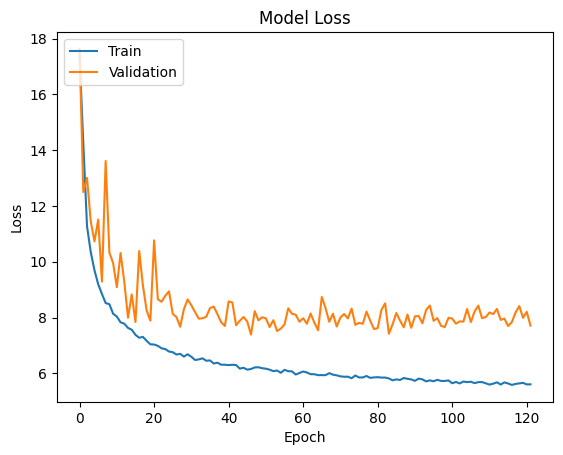

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

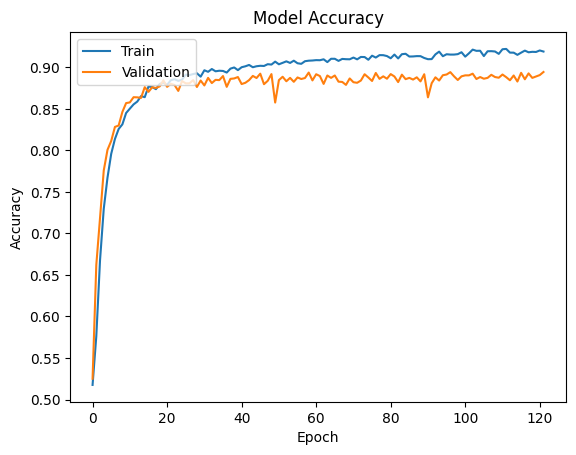

In [20]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

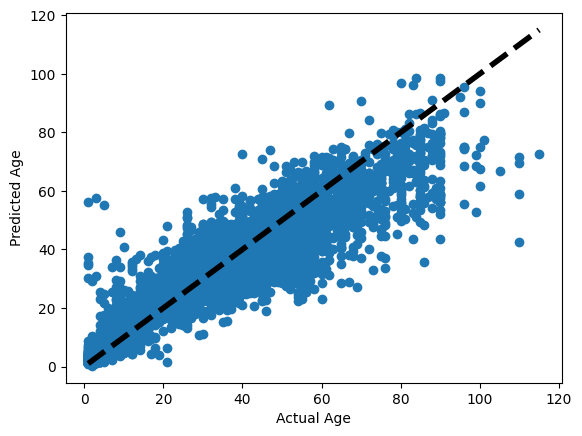

In [21]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(), Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [22]:
Pred_l = []
for i in range(len(pred[0])):
    Pred_l.append(int(np.round(pred[0][i])))

report = classification_report(Y_test_2[0], Pred_l)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3112
           1       0.94      0.80      0.86      2815

    accuracy                           0.88      5927
   macro avg       0.89      0.88      0.88      5927
weighted avg       0.89      0.88      0.88      5927



C:\Users\shali\AppData\Local\Temp\ipykernel_9112\4094423374.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Pred_l.append(int(np.round(pred[0][i])))


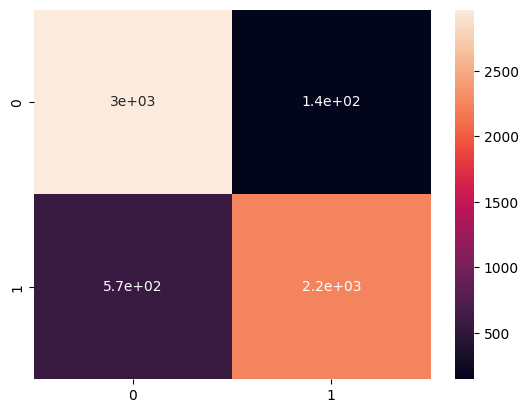

In [23]:
results = confusion_matrix(Y_test_2[0], Pred_l)
sns.heatmap(results, annot=True)
plt.show()


In [24]:
def test_image(ind, images_f, images_f_2, Model):
    plt.imshow(images_f[ind])
    image_test = images_f_2[ind]
    pred_l = Model.predict(np.array([image_test]))
    sex_f = ['Male', 'Female']
    age = int(np.round(pred_l[1][0]))
    sex = int(np.round(pred_l[0][0]))
    print("Predicted Age is " + str(age))
    print("Predicted Gender is " + sex_f[sex])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Age is 75
Predicted Gender is Female


C:\Users\shali\AppData\Local\Temp\ipykernel_9112\1425639931.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age = int(np.round(pred_l[1][0]))
C:\Users\shali\AppData\Local\Temp\ipykernel_9112\1425639931.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sex = int(np.round(pred_l[0][0]))


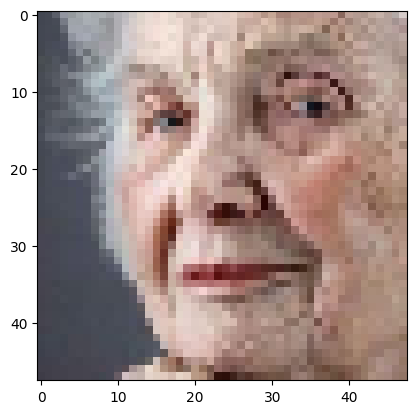

In [25]:
test_image(4, images_f, images_f_2, Model)


In [26]:
def process_meeting_room(images, model):
    if len(images) < 2:
        return "Not enough people in the meeting room"
    
    male_count = 0
    female_count = 0
    predictions = []
    
    for image in images:
        image_resized = cv2.resize(image, (48, 48)) / 255.0
        shirt_color = get_shirt_color(image)
        pred_l = model.predict(np.array([image_resized]))
        age = int(np.round(pred_l[1][0]))
        sex = int(np.round(pred_l[0][0]))
        
        if shirt_color == 'white':
            age = 23
        elif shirt_color == 'black':
            age = 'child'
        
        gender = 'Female' if sex == 1 else 'Male'
        if gender == 'Male':
            male_count += 1
        else:
            female_count += 1
        
        predictions.append((gender, age))
    
    return male_count, female_count, predictions

Example usage

In [27]:
meeting_images = [images[4], images[23], images[168]]
male_count, female_count, predictions = process_meeting_room(meeting_images, Model)
print(f'Male count: {male_count}, Female count: {female_count}, Predictions: {predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Male count: 1, Female count: 2, Predictions: [('Female', 'child'), ('Male', 'child'), ('Female', 'child')]


C:\Users\shali\AppData\Local\Temp\ipykernel_9112\2925303515.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age = int(np.round(pred_l[1][0]))
C:\Users\shali\AppData\Local\Temp\ipykernel_9112\2925303515.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sex = int(np.round(pred_l[0][0]))


Function to process a frame and predict age and gender

In [33]:
def process_frame(frame):
    # Preprocess the frame
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))
    image = np.expand_dims(image, axis=0) / 255.0

    # Make prediction
    pred = Model.predict(image)
    gender = int(np.round(pred[0][0]))
    age = int(np.round(pred[1][0]))

    # Map results to labels
    gender_label = "Male" if gender == 0 else "Female"
    shirt_color = get_shirt_color(frame)
    if shirt_color == 'white':
        age = 23
    elif shirt_color == 'black':
        age = "Child"

    return gender_label, age

# Open a video capture
cap = cv2.VideoCapture(0)  # Change to 0 to use the webcam, or provide a video file path

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gender_label, age = process_frame(frame)

    # Draw the results on the frame
    cv2.putText(frame, f'Gender: {gender_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Age: {age}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Age and Gender Prediction', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close windows
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


C:\Users\shali\AppData\Local\Temp\ipykernel_9112\4006052352.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gender = int(np.round(pred[0][0]))
C:\Users\shali\AppData\Local\Temp\ipykernel_9112\4006052352.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age = int(np.round(pred[1][0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━